In [ ]:
!pip install transformers

In [0]:
#Custom Data set and Data loader has  been adapted and inspired from 
#Michael Sugimura,Github Repository:https://github.com/sugi-chan/custom_bert_pipeline
#Roberta based fine tuning adapted and inspired from:Chris McCormick and Nick Ryan. (2019, July 22). BERT Fine-Tuning Tutorial with PyTorch. Retrieved from http://www.mccormickml.com
#for all references refer README.md

In [0]:
import tensorflow as tf
import torch

import csv
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split


from transformers import BertTokenizer as bertTokenizer
from sklearn.model_selection import train_test_split
from keras.preprocessing.sequence import pad_sequences
from torch.utils.data import TensorDataset,DataLoader,RandomSampler,SequentialSampler

from sklearn.svm import SVC
from sklearn import preprocessing

from transformers import BertForSequenceClassification as bfsc,AdamW,BertConfig
from torch.utils.data import Dataset
from transformers import get_linear_schedule_with_warmup


from __future__ import absolute_import, division, print_function

import glob
import logging
import os
import random
import json

import numpy as np
import torch
from torch.utils.data import (DataLoader, RandomSampler, SequentialSampler,
                              TensorDataset)
import random
from torch.utils.data.distributed import DistributedSampler
from tqdm import tqdm_notebook, trange


from transformers import AdamW#, WarmupLinearSchedule

#from utils import (convert_examples_to_features,
                        #output_modes, processors)

logging.basicConfig(level=logging.INFO)
logger = logging.getLogger(__name__)


Using TensorFlow backend.


In [0]:
gpuname=""
device=""
y=""
preprocessedTweets=""
ids_of_sentence=[]
ids_of_sentence_words=[]


In [0]:


gpuname=tf.test.gpu_device_name()
if gpuname=='/device:GPU:0':
  print('Found GPU at :{}'.format(gpuname))
else:
  gpuname=""
if torch.cuda.is_available():
  device=torch.device("cuda")
  n_gpu=torch.cuda.device_count()
  print("The device name is %s"%torch.cuda.get_device_name(0))
else:
  print("No GPU available using only CPU instead")
  device=torch.device("cpu")




Found GPU at :/device:GPU:0
The device name is Tesla K80


In [ ]:
from google.colab import drive
drive.mount('/content/drive')

In [0]:
!unzip -P yourpassword -qq '/content/drive/My Drive/EnglishData/task_b_distant.zip' 


In [0]:
def convertToFloat(val):
    if not val:
        return 0    
    try:
        return np.float64(val)
    except:        
        return np.float64(0)


headers=['id','text','average','std']
taskb = pd.read_csv("task_b_distant.tsv", delimiter='\t',names=headers,low_memory=False,converters={"average":convertToFloat,"std":convertToFloat})
#taskb=taskb[1:]

In [0]:
len(taskb)

188975

In [0]:
#print(taskb['text'])
#print(taskb['average'])
#print(taskb['std'])

In [0]:
print(len(taskb[taskb.average >=0.5]))
print(len(taskb[taskb.average >=0.5])/len(taskb))


39424
0.20862018785553646


In [0]:
#len(englishdata1)
#39424 untargeted

In [0]:
print(len(taskb[taskb.average <0.5]))
print(len(taskb[taskb.average <0.5])/len(taskb))
#targeted 149551

149551
0.7913798121444635


In [0]:

'''#GET THE DATA FROM THE PANDAS FRAME
headers=['id','tweet','subtask_a','subtask_b','subtask_c']
englishdata = pd.read_csv("olid-training-v1.0.tsv", delimiter='\t',names=headers,low_memory=False)
englishdata=englishdata[['id','tweet','subtask_b']]
englishdata=englishdata[1:]'''

'#GET THE DATA FROM THE PANDAS FRAME\nheaders=[\'id\',\'tweet\',\'subtask_a\',\'subtask_b\',\'subtask_c\']\nenglishdata = pd.read_csv("olid-training-v1.0.tsv", delimiter=\'\t\',names=headers,low_memory=False)\nenglishdata=englishdata[[\'id\',\'tweet\',\'subtask_b\']]\nenglishdata=englishdata[1:]'

In [0]:
#englishdata = englishdata.dropna(subset=['subtask_b'])

In [0]:
#len(englishdata)

In [0]:
taskb=taskb[1:]

In [0]:
#englishdata.head()

In [0]:
'''englishtrain,englishtest= train_test_split(englishdata, test_size=0.2, random_state=42)
export_csv = englishtrain.to_csv ('/content/drive/My Drive/EnglishData/olidlearn/TrainFileEnglish.tsv', index = None, header=True)
print (englishtrain.head())
#englishtest,englishpredict= train_test_split(englishtemp, test_size=0.5, random_state=42)
export_csv = englishtest.to_csv ('/content/drive/My Drive/EnglishData/olidlearn/TestFileEnglish.tsv', index = None, header=True)
print (englishtest.head())'''
#export_csv = englishpredict.to_csv ('/content/drive/My Drive/EnglishData/predictFileEnglish.csv', index = None, header=True)
#print (englishpredict.head())

"englishtrain,englishtest= train_test_split(englishdata, test_size=0.2, random_state=42)\nexport_csv = englishtrain.to_csv ('/content/drive/My Drive/EnglishData/olidlearn/TrainFileEnglish.tsv', index = None, header=True)\nprint (englishtrain.head())\n#englishtest,englishpredict= train_test_split(englishtemp, test_size=0.5, random_state=42)\nexport_csv = englishtest.to_csv ('/content/drive/My Drive/EnglishData/olidlearn/TestFileEnglish.tsv', index = None, header=True)\nprint (englishtest.head())"

In [0]:
#max_length=

In [0]:

def giveLabel(y):
  i=0
  y1=[]
  for r in y:
    if(y[i]>=0.5):
      y1.append(1)#1 means UNT 
    else:
      y1.append(0)
    i=i+1;
  return y1

headers=['id','text','average','std']

dfnumpy=taskb.to_numpy();
x=dfnumpy[:, 1].reshape(-1, 1)
y=dfnumpy[:, 2].reshape(-1, 1)
y1=giveLabel(y)

In [0]:
#preprocessedTweets=X[:,0]

In [0]:
x_train,x_test,y_train,y_test= train_test_split(x,y1, test_size=0.2, random_state=42)


In [0]:
from sklearn.utils import shuffle
x_train,y_train=shuffle(x_train,y_train)

In [0]:
x_train

array([['Bitch bye 🤣🤣🤣this nigga swear he the elchapo of FtWorth 😭'],
       ['Southend away, up the fucking pool🍊'],
       ['Of course I would strip a fucking nut before I went to bed lmfao guess I’ll be getting no sleep thinking of ways to take this shit out'],
       ...,
       ['@USER Playing stupid and rough play with Mike'],
       ['What’s up with all these girls openly tweeting bout cheating on their man? What the fuck.. lol.'],
       ['You Dont See Shit Bitch , I deleted That Shit Gtf ,Go To Your HAPPY Home OR Sum']],
      dtype=object)

In [0]:
'''x_train,y_train=readDataTrain()
x_test,y_test=readDataTest()
'''

'x_train,y_train=readDataTrain()\nx_test,y_test=readDataTest()\n'

In [0]:
#print(preprocessedTweets[0:5])

In [0]:
set(y_test)

{0, 1}

In [0]:
###IMPORTANT
'''xtest,x_test_mask=giveIds(x_test.flatten(),y_test)
x_test_pytorch=torch.tensor(xtest)
y_test_pytorch=torch.tensor(y_test)
x_test_mask_pytorch=torch.tensor(x_test_mask)
tedata=TensorDataset(x_test_pytorch,x_test_mask_pytorch,y_test_pytorch)
tesampler=RandomSampler(tedata)
bsize=64
tedataloader=DataLoader(tedata,sampler=tesampler,batch_size=bsize)
print(len(xtest))
print(len(y_test))
len(x_train)
'''

'xtest,x_test_mask=giveIds(x_test.flatten(),y_test)\nx_test_pytorch=torch.tensor(xtest)\ny_test_pytorch=torch.tensor(y_test)\nx_test_mask_pytorch=torch.tensor(x_test_mask)\ntedata=TensorDataset(x_test_pytorch,x_test_mask_pytorch,y_test_pytorch)\ntesampler=RandomSampler(tedata)\nbsize=64\ntedataloader=DataLoader(tedata,sampler=tesampler,batch_size=bsize)\nprint(len(xtest))\nprint(len(y_test))\nlen(x_train)\n'

In [0]:
from transformers import RobertaForSequenceClassification as bfsc,AdamW,RobertaConfig
from transformers import RobertaModel, RobertaTokenizer
from transformers import RobertaForSequenceClassification, RobertaConfig

config = RobertaConfig.from_pretrained('roberta-base',output_attentions=False,output_hidden_states=False,num_labels=2)
tokenizer = RobertaTokenizer.from_pretrained('roberta-base')
model = RobertaForSequenceClassification(config)
model.cuda()

INFO:filelock:Lock 140079551118304 acquired on /root/.cache/torch/transformers/e1a2a406b5a05063c31f4dfdee7608986ba7c6393f7f79db5e69dcd197208534.a7ab0e5de2d8321d6d6a15b199110f2c99be72976b7d151423cb8d8c261a13b6.lock
INFO:transformers.file_utils:https://s3.amazonaws.com/models.huggingface.co/bert/roberta-base-config.json not found in cache or force_download set to True, downloading to /root/.cache/torch/transformers/tmpihd27clr


INFO:transformers.file_utils:storing https://s3.amazonaws.com/models.huggingface.co/bert/roberta-base-config.json in cache at /root/.cache/torch/transformers/e1a2a406b5a05063c31f4dfdee7608986ba7c6393f7f79db5e69dcd197208534.a7ab0e5de2d8321d6d6a15b199110f2c99be72976b7d151423cb8d8c261a13b6
INFO:transformers.file_utils:creating metadata file for /root/.cache/torch/transformers/e1a2a406b5a05063c31f4dfdee7608986ba7c6393f7f79db5e69dcd197208534.a7ab0e5de2d8321d6d6a15b199110f2c99be72976b7d151423cb8d8c261a13b6
INFO:filelock:Lock 140079551118304 released on /root/.cache/torch/transformers/e1a2a406b5a05063c31f4dfdee7608986ba7c6393f7f79db5e69dcd197208534.a7ab0e5de2d8321d6d6a15b199110f2c99be72976b7d151423cb8d8c261a13b6.lock
INFO:transformers.configuration_utils:loading configuration file https://s3.amazonaws.com/models.huggingface.co/bert/roberta-base-config.json from cache at /root/.cache/torch/transformers/e1a2a406b5a05063c31f4dfdee7608986ba7c6393f7f79db5e69dcd197208534.a7ab0e5de2d8321d6d6a15b1991

INFO:filelock:Lock 140079551117744 acquired on /root/.cache/torch/transformers/d0c5776499adc1ded22493fae699da0971c1ee4c2587111707a4d177d20257a2.ef00af9e673c7160b4d41cfda1f48c5f4cba57d5142754525572a846a1ab1b9b.lock
INFO:transformers.file_utils:https://s3.amazonaws.com/models.huggingface.co/bert/roberta-base-vocab.json not found in cache or force_download set to True, downloading to /root/.cache/torch/transformers/tmp103jy9vl


INFO:transformers.file_utils:storing https://s3.amazonaws.com/models.huggingface.co/bert/roberta-base-vocab.json in cache at /root/.cache/torch/transformers/d0c5776499adc1ded22493fae699da0971c1ee4c2587111707a4d177d20257a2.ef00af9e673c7160b4d41cfda1f48c5f4cba57d5142754525572a846a1ab1b9b
INFO:transformers.file_utils:creating metadata file for /root/.cache/torch/transformers/d0c5776499adc1ded22493fae699da0971c1ee4c2587111707a4d177d20257a2.ef00af9e673c7160b4d41cfda1f48c5f4cba57d5142754525572a846a1ab1b9b
INFO:filelock:Lock 140079551117744 released on /root/.cache/torch/transformers/d0c5776499adc1ded22493fae699da0971c1ee4c2587111707a4d177d20257a2.ef00af9e673c7160b4d41cfda1f48c5f4cba57d5142754525572a846a1ab1b9b.lock


INFO:filelock:Lock 140079551117744 acquired on /root/.cache/torch/transformers/b35e7cd126cd4229a746b5d5c29a749e8e84438b14bcdb575950584fe33207e8.70bec105b4158ed9a1747fea67a43f5dee97855c64d62b6ec3742f4cfdb5feda.lock
INFO:transformers.file_utils:https://s3.amazonaws.com/models.huggingface.co/bert/roberta-base-merges.txt not found in cache or force_download set to True, downloading to /root/.cache/torch/transformers/tmpruwrtqcs


INFO:transformers.file_utils:storing https://s3.amazonaws.com/models.huggingface.co/bert/roberta-base-merges.txt in cache at /root/.cache/torch/transformers/b35e7cd126cd4229a746b5d5c29a749e8e84438b14bcdb575950584fe33207e8.70bec105b4158ed9a1747fea67a43f5dee97855c64d62b6ec3742f4cfdb5feda
INFO:transformers.file_utils:creating metadata file for /root/.cache/torch/transformers/b35e7cd126cd4229a746b5d5c29a749e8e84438b14bcdb575950584fe33207e8.70bec105b4158ed9a1747fea67a43f5dee97855c64d62b6ec3742f4cfdb5feda
INFO:filelock:Lock 140079551117744 released on /root/.cache/torch/transformers/b35e7cd126cd4229a746b5d5c29a749e8e84438b14bcdb575950584fe33207e8.70bec105b4158ed9a1747fea67a43f5dee97855c64d62b6ec3742f4cfdb5feda.lock
INFO:transformers.tokenization_utils:loading file https://s3.amazonaws.com/models.huggingface.co/bert/roberta-base-vocab.json from cache at /root/.cache/torch/transformers/d0c5776499adc1ded22493fae699da0971c1ee4c2587111707a4d177d20257a2.ef00af9e673c7160b4d41cfda1f48c5f4cba57d51427

RobertaForSequenceClassification(
  (roberta): RobertaModel(
    (embeddings): RobertaEmbeddings(
      (word_embeddings): Embedding(50265, 768, padding_idx=1)
      (position_embeddings): Embedding(514, 768, padding_idx=1)
      (token_type_embeddings): Embedding(1, 768)
      (LayerNorm): LayerNorm((768,), eps=1e-05, elementwise_affine=True)
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (encoder): BertEncoder(
      (layer): ModuleList(
        (0): BertLayer(
          (attention): BertAttention(
            (self): BertSelfAttention(
              (query): Linear(in_features=768, out_features=768, bias=True)
              (key): Linear(in_features=768, out_features=768, bias=True)
              (value): Linear(in_features=768, out_features=768, bias=True)
              (dropout): Dropout(p=0.1, inplace=False)
            )
            (output): BertSelfOutput(
              (dense): Linear(in_features=768, out_features=768, bias=True)
              (LayerNorm): LayerNorm

In [0]:

#torch.save({'state_dict': model.state_dict()}, '/content/drive/My Drive/EnglishData/robertabwoprenglish.pth.tar')
checkpoint = torch.load('/content/drive/My Drive/EnglishData/taskb/epoch2/robertabwoprenglish.pth.tar')
model.load_state_dict(checkpoint['state_dict'])
  

<All keys matched successfully>

In [0]:
params=list(model.named_parameters())

In [0]:
no_decay = ["bias", "beta","LayerNorm.weight","gamma"]
optimizer_grouped_parameters = [
{
"params": [p for n, p in model.named_parameters() if not any(nd in n for nd in no_decay)],
"weight_decay": 0.01,
},
{"params": [p for n, p in model.named_parameters() if any(nd in n for nd in no_decay)], "weight_decay": 0.0},
]

In [0]:
optimizer=AdamW(model.parameters(),lr=3e-5,eps=1e-8)

In [0]:
from sklearn.metrics import f1_score
from sklearn.metrics import accuracy_score

def calculateF1Score(predictions,labels):
  #rowwise return the index of the max element ie 0 or 1 depending on the maximum value returned
  predictionArgmax=np.argmax(predictions,axis=1).flatten()
  labelsFlattend=labels.flatten()
  print("Predictions Argmax",predictionArgmax)
  print("labels Flattened",labelsFlattend)   
  return f1_score(labelsFlattend, predictionArgmax, average='macro'),accuracy_score(labelsFlattend, predictionArgmax)



In [0]:
from sklearn.svm import SVC
from sklearn import preprocessing

le = preprocessing.LabelEncoder()
#print(y_train.shape)
#print(y_test.shape)
#print(y_predict.shape)
z=le.fit_transform([0, 1])
yTrain=le.transform(y_train)
print(le.get_params())
print(yTrain.shape)
print(le.classes_)
yTest=le.transform(y_test)
print(le.classes_)

{}
(151179,)
[0 1]
[0 1]


In [0]:
MAXLENGTH=64

In [0]:
class EnglishTrainDataset(Dataset):
    def __init__(self,xytrain):
        self.xytrain = xytrain
        self.maxlength=MAXLENGTH
       
    def __getitem__(self, index):
        tokenized_review = tokenizer.tokenize(str(self.xytrain[0][index].flatten()))
        if len(tokenized_review) > self.maxlength:
            #print(tokenized_review)
            tokenized_review = tokenized_review[:self.maxlength]
        
        
        ids_of_sentence_word  = tokenizer.convert_tokens_to_ids(tokenized_review)
        padding = [0] * (self.maxlength - len(ids_of_sentence_word))
        ids_of_sentence_word += padding
        assert len(ids_of_sentence_word) == self.maxlength
        #print(ids_of_sentence_word)
        #attention_mask = [int(b > 0) for b in ids_of_sentence_word] 
        x_train_pytorch = torch.tensor(ids_of_sentence_word)
        y_train_pytorch=torch.tensor(self.xytrain[1][index])
        
        return x_train_pytorch,y_train_pytorch
        #return [1,2,3]
        
    def __len__(self):
        return len(self.xytrain[0])
 

'''
z=0;
for batch_idx, data in enumerate(tdataloader): 
  if z==100:
    break;
  z=z+1;'''

'\nz=0;\nfor batch_idx, data in enumerate(tdataloader): \n  if z==100:\n    break;\n  z=z+1;'

In [0]:
class EnglishTestDataset(Dataset):
    def __init__(self,xytest):
        self.xytest = xytest
        self.maxlength=MAXLENGTH
       
    def __getitem__(self, index):
        tokenized_review = tokenizer.tokenize(str(self.xytest[0][index].flatten()))
        if len(tokenized_review) > self.maxlength:
            #print(tokenized_review)
            tokenized_review = tokenized_review[:self.maxlength]
        
        
        ids_of_sentence_word  = tokenizer.convert_tokens_to_ids(tokenized_review)
        padding = [0] * (self.maxlength - len(ids_of_sentence_word))
        ids_of_sentence_word += padding
        #assert len(ids_of_sentence_word) == self.maxlength
        #print(ids_of_sentence_word)
        #attention_mask = [int(b > 0) for b in ids_of_sentence_word] 
        x_test_pytorch = torch.tensor(ids_of_sentence_word)
        y_test_pytorch=torch.tensor(self.xytest[1][index])
        #x_test_mask_pytorch=torch.tensor(attention_mask)
        
        return x_test_pytorch,y_test_pytorch
        #return [1,2,3]
        
    def __len__(self):
        return len(self.xytest[0])



In [0]:
#xytrain=[x_train[:8000],y_train[:8000]]\
#MAXLENGTH=giveIds(x_train[0])
xytrain=[x_train,yTrain]
#tokenizer=bertTokenizer.from_pretrained('bert-base-uncased',do_lower_case=True)
tdataset = EnglishTrainDataset(xytrain)
tsampler=RandomSampler(tdataset)
tdataloader = DataLoader(tdataset, batch_size=32, num_workers=1, shuffle=False,sampler=tsampler)
      

In [0]:

#tokenized_review = tokenizer.tokenize(str(xytest[0][0].flatten()))
 #y_test_pytorch=torch.tensor(y_test[0])
 #y_test[0]
 xytrain[0][1]

array(['@USER Democrats are destroying America their souls belong to Satan'],
      dtype=object)

In [0]:
#tokenized_review

In [0]:

#xytest=[x_test[:8000],y_test[:8000]]
xytest=[x_test,yTest]
#tokenizer=bertTokenizer.from_pretrained('bert-base-uncased',do_lower_case=True)
tedataset = EnglishTestDataset(xytest) 
tesampler=RandomSampler(tedataset)
tedataloader = DataLoader(tedataset, batch_size=32, num_workers=1, shuffle=False,sampler=tesampler)
#trainData(tdataloader,tedataloader)

In [0]:

epochs=4
total_steps=len(tdataloader)*epochs
sch=get_linear_schedule_with_warmup(optimizer,
                                    num_warmup_steps=0,num_training_steps=total_steps)



In [0]:
'''import random
import time 

def set_seed(seed,ngpu):
  random.seed(seed)
  np.random.seed(seed)
  torch.manual_seed(seed)
  if ngpu > 0:
        torch.cuda.manual_seed_all(seed)
      
set_seed(42,torch.cuda.device_count())
#remove later

epochs=4
lossList=[]
max_grad_norm=1.0
for e in range(0, epochs):
    print("Start Epoch Number",(e + 1))
    print("Start Training")
    

    #Amount of time taken for training
    t1 = time.time()
    tr_loss, logging_loss = 0.0, 0.0
    model.train()
    tsteps=0
    for step, batch in enumerate(tdataloader):
        if step % 50 == 0 and not step == 0:
            print("Batch Completed  {:,}  of  {:,}.    Elapsed time is  {}".format(step, len(tdataloader),time.time() - t1))
        batch = tuple(t.to(device) for t in batch)
        inputs = {"input_ids": batch[0], "labels": batch[1]}
        model.zero_grad()     
        outputs = model(inputs["input_ids"],token_type_ids=None, labels=inputs["labels"])
        #print(type(outputs))
        loss, prediction_scores = outputs[:2]
        #print(loss)
        loss.backward()
        tr_loss += loss.item()
        torch.nn.utils.clip_grad_norm_(model.parameters(), max_grad_norm)
        tsteps+=1
        optimizer.step()
        sch.step()
    a_tr_loss = tr_loss /(tsteps)               
    lossList.append(a_tr_loss)
    print(" The training loss incured is  {0:.3f}".format(a_tr_loss))
    t2=time.time()
    print("  Training one epoch time taken",t2-t1)
    print(" Validation starts here ")
    t1 = time.time()
    model.eval()
    eval_loss = 0
    nb_eval_steps = 0
    eval_f1=0
    eval_acc=0
    
    for batch_idx, data in enumerate(tedataloader):
        
        batch = tuple(t.to(device) for t in data)            
        inputs = {"input_ids": batch[0], "labels": batch[1]}
        with torch.no_grad():        
           outputs = model(inputs["input_ids"],token_type_ids=None)
        logits = outputs[0]
        logits = logits.detach().cpu().numpy()
        label_ids = (inputs["labels"]).to('cpu').numpy()
        tmpf1score,tmpaccscore = calculateF1Score(logits, label_ids)
        eval_f1 = eval_f1+tmpf1score
        eval_acc=eval_acc+tmpaccscore
        nb_eval_steps += 1
        #print(" TEMP F1 score: {0:.3f}".format(tmpf1score))
        #print("TEMP  Accuracy score: {0:.3f}".format(tmpaccscore))
    torch.save({'state_dict': model.state_dict()}, '/content/drive/My Drive/EnglishData/robertabwoprenglish.pth.tar')
    print("  F1 score: {0:.3f}".format(eval_f1/nb_eval_steps))
    print("  Accuracy score: {0:.3f}".format(eval_acc/nb_eval_steps))
    t2=time.time()
    print("  Validating one epoch time taken ",t2-t1)
      
    
print("ALL DONE!!!")'''

Streaming output truncated to the last 5000 lines.
labels Flattened [0 0 1 0 0 0 0 1 0 0 1 0 0 0 1 0 0 1 0 0 0 0 0 0 0 0 0 1 0 0 0 0]
Predictions Argmax [0 0 1 0 0 0 0 0 0 0 1 0 1 0 0 0 0 0 0 0 1 1 0 0 1 1 1 1 0 0 1 0]
labels Flattened [0 0 1 0 0 0 0 0 0 0 1 0 0 0 0 0 0 0 0 0 1 1 0 0 1 1 1 1 0 0 1 1]
Predictions Argmax [0 0 0 0 0 1 0 0 0 0 1 0 0 0 0 0 0 0 0 0 0 1 0 0 0 0 0 0 0 0 0 0]
labels Flattened [0 0 0 0 0 1 0 0 0 0 1 0 0 0 0 0 0 0 0 0 0 1 0 0 0 1 0 0 1 0 0 1]
Predictions Argmax [0 0 0 1 0 0 0 0 0 0 0 1 0 1 0 0 1 0 0 1 0 0 0 0 0 1 0 0 1 0 0 1]
labels Flattened [1 0 0 1 0 0 0 0 1 0 0 1 0 0 0 0 1 1 0 1 0 0 0 0 0 0 0 0 1 0 0 1]
Predictions Argmax [0 0 0 0 0 0 1 0 0 1 0 0 0 1 0 0 0 0 0 0 0 0 0 0 0 0 0 1 0 1 0 0]
labels Flattened [0 0 0 0 0 0 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 0 0 1 0 0]
Predictions Argmax [0 0 0 0 1 1 0 0 0 0 0 1 0 0 0 0 0 0 0 0 0 0 0 0 1 0 0 0 0 0 0 0]
labels Flattened [0 0 0 0 1 1 0 0 0 0 0 1 0 0 0 0 0 0 0 0 0 0 0 0 1 0 0 0 0 0 0 0]
Predictions Argmax [0 0 0 

In [0]:
print(type(outputs))

<class 'tuple'>


In [0]:

#GET THE DATA FROM THE PANDAS FRAME
headers=['id','tweet','subtask_a','subtask_b','subtask_c']
englishdata = pd.read_csv("/content/drive/My Drive/EnglishData/OLIDv1.0/olid-training-v1.0.tsv", delimiter='\t',names=headers,low_memory=False)
englishdata=englishdata[['id','tweet','subtask_b']]
englishdata=englishdata[1:]


In [0]:
englishdata = englishdata.dropna(subset=['subtask_b'])

In [0]:
print(englishdata.head()['tweet'])
print(englishdata.head()['subtask_b'])
print(len(englishdata))

1    @USER She should ask a few native Americans wh...
2    @USER @USER Go home you’re drunk!!! @USER #MAG...
4    @USER Someone should'veTaken" this piece of sh...
6                    @USER Liberals are all Kookoo !!!
7                     @USER @USER Oh noes! Tough shit.
Name: tweet, dtype: object
1    UNT
2    TIN
4    UNT
6    TIN
7    UNT
Name: subtask_b, dtype: object
4400


In [0]:

def giveLabel2(y):
  i=0
  y1=[]
  for r in y:
    if(y[i]=='UNT'):
      y1.append(1)#1 means UNT 
    else:
      y1.append(0)
    i=i+1;
  return y1

dfnumpy=englishdata.to_numpy()
x_pred1=dfnumpy[:, 1].reshape(-1, 1)
y_pred1=dfnumpy[:, 2].reshape(-1, 1)
y1=giveLabel2(y_pred1)

In [0]:
from sklearn.svm import SVC
from sklearn import preprocessing

le = preprocessing.LabelEncoder()
y_pred1=le.fit_transform(y1)
print(le.classes_)


[0 1]


In [0]:
print(y1.count(0))
print(y1.count(1))
print(len(y_pred1))

3876
524
4400


In [0]:
data = pd.DataFrame()
data['predicted']=['X']
data['true']=['X']
data.to_csv('/content/drive/My Drive/EnglishData/subtaskB1/OLIDSUBTASKBBBROBERTA.csv') 


In [0]:
from sklearn.metrics import f1_score
from sklearn.metrics import accuracy_score

def calculateF1Score1(predictions,labels):
  #rowwise return the index of the max element ie 0 or 1 depending on the maximum value returned
  predictionArgmax=np.argmax(predictions,axis=1).flatten()
  labelsFlattend=labels.flatten()
  print("Predictions Argmax",predictionArgmax)
  print("labels Flattened",labelsFlattend)
  data=pd.read_csv('/content/drive/My Drive/EnglishData/subtaskB1/OLIDSUBTASKBBBROBERTA.csv')#,converters={'predicted': eval,'true': eval})
  ypred=data['predicted'].to_numpy().tolist()
  for t in predictionArgmax:
    ypred.append(t)

  print(len(ypred))
  ytrue=data['true'].to_numpy().tolist()
  for t in labelsFlattend:
    ytrue.append(t)
  data = pd.DataFrame()
  data['predicted']=ypred
  data['true']=ytrue
  data.to_csv('/content/drive/My Drive/EnglishData/subtaskB1/OLIDSUBTASKBBBROBERTA.csv') 

  return f1_score(labelsFlattend, predictionArgmax, average='macro'),accuracy_score(labelsFlattend, predictionArgmax)



In [0]:
class EnglishPredictedDataset(Dataset):
     def __init__(self,xytest):
        self.xytest = xytest
        self.maxlength=MAXLENGTH
       
    def __getitem__(self, index):
        tokenized_review = tokenizer.tokenize(str(self.xytest[0][index].flatten()))
        if len(tokenized_review) > self.maxlength:
            #print(tokenized_review)
            tokenized_review = tokenized_review[:self.maxlength]
        
        
        ids_of_sentence_word  = tokenizer.convert_tokens_to_ids(tokenized_review)
        padding = [0] * (self.maxlength - len(ids_of_sentence_word))
        ids_of_sentence_word += padding
        #assert len(ids_of_sentence_word) == self.maxlength
        #print(ids_of_sentence_word)
        #attention_mask = [int(b > 0) for b in ids_of_sentence_word] 
        x_test_pytorch = torch.tensor(ids_of_sentence_word)
        y_test_pytorch=torch.tensor(self.xytest[1][index])
        #x_test_mask_pytorch=torch.tensor(attention_mask)
        
        return x_test_pytorch,y_test_pytorch
        #return [1,2,3]
        
    def __len__(self):
        return len(self.xytest[0])

In [0]:
#trainData(tdataloader,tedataloader)
#xytest=[x_test[:8000],y_test[:8000]]
xypred1=[x_pred1,y_pred1,]
ptdataset = EnglishPredictedDataset(xypred1) 
tokenizer = RobertaTokenizer.from_pretrained('roberta-base')

ptsampler=RandomSampler(ptdataset)
ptdataloader = DataLoader(ptdataset, batch_size=32, num_workers=1, shuffle=False,sampler=ptsampler)
#trainData(tdataloader,tedataloader)

INFO:transformers.tokenization_utils:loading file https://s3.amazonaws.com/models.huggingface.co/bert/roberta-base-vocab.json from cache at /root/.cache/torch/transformers/d0c5776499adc1ded22493fae699da0971c1ee4c2587111707a4d177d20257a2.ef00af9e673c7160b4d41cfda1f48c5f4cba57d5142754525572a846a1ab1b9b
INFO:transformers.tokenization_utils:loading file https://s3.amazonaws.com/models.huggingface.co/bert/roberta-base-merges.txt from cache at /root/.cache/torch/transformers/b35e7cd126cd4229a746b5d5c29a749e8e84438b14bcdb575950584fe33207e8.70bec105b4158ed9a1747fea67a43f5dee97855c64d62b6ec3742f4cfdb5feda


In [0]:
import random
import time 

def set_seed(seed,ngpu):
  random.seed(seed)
  np.random.seed(seed)
  torch.manual_seed(seed)
  if ngpu > 0:
        torch.cuda.manual_seed_all(seed)
      

lossList=[]
max_grad_norm=1.0

checkpoint = torch.load('/content/drive/My Drive/EnglishData/taskb/epoch2/robertabwoprenglish.pth.tar')
model.load_state_dict(checkpoint['state_dict'])
t1 = time.time()
model.eval()
eval_loss = 0
nb_eval_steps = 0
eval_f1=0
eval_acc=0
    
for batch_idx, data in enumerate(ptdataloader):
        
        batch = tuple(t.to(device) for t in data)            
        inputs = {"input_ids": batch[0], "labels": batch[1]}
        with torch.no_grad():        
           outputs = model(inputs["input_ids"],token_type_ids=None)
        logits = outputs[0]
        logits = logits.detach().cpu().numpy()
        label_ids = (inputs["labels"]).to('cpu').numpy()
        tmpf1score,tmpaccscore = calculateF1Score1(logits, label_ids)
        eval_f1 = eval_f1+tmpf1score
        eval_acc=eval_acc+tmpaccscore
        nb_eval_steps += 1
        #print(" TEMP F1 score: {0:.3f}".format(tmpf1score))
        #print("TEMP  Accuracy score: {0:.3f}".format(tmpaccscore))
print("  F1 score: {0:.3f}".format(eval_f1/nb_eval_steps))
print("  Accuracy score: {0:.3f}".format(eval_acc/nb_eval_steps))
t2=time.time()
print("  Validating one epoch time taken ",t2-t1)
      
    

Predictions Argmax [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
labels Flattened [0 0 0 0 1 0 0 1 0 0 0 0 0 0 0 0 0 1 0 0 0 0 0 0 0 1 0 0 0 0 0 1]
33
Predictions Argmax [0 0 0 0 0 0 0 0 1 0 1 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
labels Flattened [0 0 0 0 0 0 0 1 1 0 0 1 0 1 0 0 0 0 1 0 0 0 0 0 0 0 0 1 0 0 0 0]
65
Predictions Argmax [0 0 0 0 0 0 0 0 1 0 0 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
labels Flattened [0 0 1 0 1 0 0 0 1 0 0 1 0 0 0 0 0 0 0 0 1 0 0 0 0 0 0 1 1 0 0 0]
97
Predictions Argmax [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 1 0 0 0]
labels Flattened [1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 0 0 0 0 0 0 0 1 0 1 1 0 0 0]
129
Predictions Argmax [0 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 0 1 1 0 0 0]
labels Flattened [0 1 1 0 0 0 0 0 0 0 0 0 0 1 0 0 0 0 0 0 0 0 0 0 0 1 0 1 0 0 1 0]
161
Predictions Argmax [0 1 0 0 0 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 0 0]
labels Flattened [0 0 1 0 0 1 0 0 0 1 0 0 0 0 0 0 0 0 0 0 

In [ ]:
def toLabels(i):
  if i=='0':
    return 'TIN'
  elif i =='1':
    return 'UNT'
  
tweetsOLID=englishdata[['id','tweet']]
print(len(tweetsOLID))
dfnumpy=tweetsOLID.to_numpy()
TWEETS1=dfnumpy[:, 1].reshape(-1, 1).tolist()
teets=np.squeeze(TWEETS1).tolist()
print(teets)
print(len(TWEETS1))
data=pd.read_csv('/content/drive/My Drive/EnglishData/subtaskB1/OLIDSUBTASKBBBROBERTA.csv')
ypred=data['predicted'].to_numpy().tolist()
ypred=ypred[1:]
ypred=[toLabels(i) for i in ypred]
#ypred=[ypred[i].flatten().tolist() for i in range(len(ypred))]
print(ypred)
print(len(ypred))
ytrue=data['true'].to_numpy().tolist()
ytrue=ytrue[1:]
ytrue=[toLabels(i) for i in ytrue]
#ytrue=[ytrue[i].flatten().tolist() for i in range(len(ytrue))]

print(ytrue)
print(len(ytrue))

data = pd.DataFrame()
data['tweets']=teets
data['predicted']=ypred
data['true']=ytrue
data.to_csv('/content/drive/My Drive/EnglishData/subtaskB1/olidfinalb.csv') 


In [ ]:
print("TARGETED BUT PREDICTED UNTARGETED")
for i,y in enumerate(ypred):
  if ypred[i]=='UNT' and ytrue[i]=="TIN":
    print(teets[i])

In [ ]:
print("UNTARGETED BUT PREDICTED TARGETED")
for i,y in enumerate(ypred):
  if ypred[i]=='TIN' and ytrue[i]=="UNT":
    print(teets[i])

In [0]:
from sklearn.metrics import confusion_matrix
cnf=confusion_matrix(ytrue, ypred, labels=['UNT', 'TIN'])
print(cnf)

[[ 161  363]
 [  73 3803]]


/usr/local/lib/python3.6/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm
INFO:numexpr.utils:NumExpr defaulting to 4 threads.


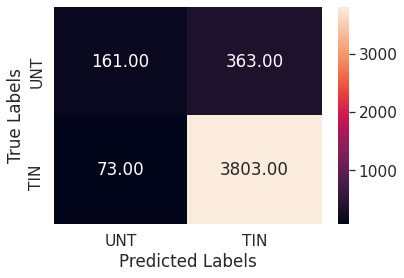

In [0]:
import seaborn as sn
import pandas as pd
import matplotlib.pyplot as plt



df_cm = pd.DataFrame(cnf,['UNT', 'TIN'], ['UNT', 'TIN'])
# plt.figure(figsize=(10,7))
sn.set(font_scale=1.4) # for label size
sn.heatmap(df_cm, annot=True,fmt='.2f') # font size
plt.xlabel("Predicted Labels")
plt.ylabel("True Labels")

plt.show()

In [0]:
def readData1():
  headers=['id','ypredicted']
  greekdataBaseline = pd.read_csv("/content/drive/My Drive/EnglishData/subtaskB1/test_b_baseline.csv", delimiter=',',names=headers)
  #,converters={"id":convertToInt}       
  #greekdataBaseline.id = greekdataBaseline.id.astype(int)
  #greekdataBaseline=greekdataBaseline[1:]
  print(greekdataBaseline.head())
  print(greekdataBaseline.shape)

  headers=['id','tweet']
  greekDataTest = pd.read_csv("/content/drive/My Drive/EnglishData/subtaskB1/test_b_tweets.tsv", delimiter='\t',names=headers)
                                #converters={"id":convertToInt})
  #greekDataTest=greekDataTest[1:]
  print(greekDataTest.head())
  #print(greekDataTest.dtypes)
  print(greekDataTest.shape)
  result = pd.merge(greekDataTest, greekdataBaseline, on='id', how='inner')
  print(result.head())
  print(result.dtypes)
  print(result.shape)

  #result=
  #result.sort_values(by=['id'], inplace=True)
  #print(result.head())
  dfnumpy=result.to_numpy();
  X=dfnumpy[:, 1].reshape(-1, 1)
  y=dfnumpy[:, 2].reshape(-1, 1)
  tid=dfnumpy[:, 0].reshape(-1, 1)
  preprocessedTweets=X[:,0]
  return preprocessedTweets,y,tid

In [0]:
preprocessedTweets,y,tid=readData1()

    id ypredicted
0  BC0        TIN
1  BC1        TIN
2  BC2        TIN
3  BC3        TIN
4  BC4        TIN
(1422, 2)
    id                                              tweet
0   id                                              tweet
1  BC0  Then to top it completely the fuck off my trai...
2  BC1  To which, of course, many Slovenes will respon...
3  BC2   @USER it means go away with your sorry ass kkkkk
4  BC3  @USER @USER And he’s closer to trump’s ass. Gr...
(1423, 2)
    id                                              tweet ypredicted
0  BC0  Then to top it completely the fuck off my trai...        TIN
1  BC1  To which, of course, many Slovenes will respon...        TIN
2  BC2   @USER it means go away with your sorry ass kkkkk        TIN
3  BC3  @USER @USER And he’s closer to trump’s ass. Gr...        TIN
4  BC4  Looking back at old photos of me makes me phys...        TIN
id            object
tweet         object
ypredicted    object
dtype: object
(1422, 3)


In [0]:
ftid=[]
for t in tid.flatten().tolist():
  ftid.append(int(t.split("BC")[1]))

In [0]:
class GreekPredictDataset(Dataset):
    def __init__(self,xypredict):
        self.xypredict = xypredict
        self.maxlength=64
       
    def __getitem__(self, index):
        tokenized_review = tokenizer.tokenize(str(self.xypredict[0][index]))
        if len(tokenized_review) > self.maxlength:
            #print(tokenized_review)
            tokenized_review = tokenized_review[:self.maxlength]
        
        
        ids_of_sentence_word  = tokenizer.convert_tokens_to_ids(tokenized_review)
        padding = [0] * (self.maxlength - len(ids_of_sentence_word))
        ids_of_sentence_word += padding
        #assert len(ids_of_sentence_word) == self.maxlength
        #print(ids_of_sentence_word)
        #attention_mask = [int(b > 0) for b in ids_of_sentence_word] 
        x_predict_pytorch = torch.tensor(ids_of_sentence_word)
        y_predict_pytorch=torch.tensor(self.xypredict[1][index])
        tid_predict_pytorch=torch.tensor(self.xypredict[2][index])
        
        return x_predict_pytorch,y_predict_pytorch,tid_predict_pytorch
       
    def __len__(self):
        return len(self.xypredict[0])
 

In [0]:
data = pd.DataFrame()
data['predicted']=['X']
data['true']=['X']
data.to_csv('/content/drive/My Drive/EnglishData/subtaskB1/ALLINDSUBTASKBBBROBERTA.csv') 


In [0]:
from sklearn.metrics import f1_score
from sklearn.metrics import accuracy_score

def calculateF1Score2(predictions,labels):
  #rowwise return the index of the max element ie 0 or 1 depending on the maximum value returned
  predictionArgmax=np.argmax(predictions,axis=1).flatten()
  labelsFlattend=labels.flatten()
  print("Predictions Argmax",predictionArgmax)
  print("labels Flattened",labelsFlattend)
  data=pd.read_csv('/content/drive/My Drive/EnglishData/subtaskB1/ALLINDSUBTASKBBBROBERTA.csv')#,converters={'predicted': eval,'true': eval})
  ypred=data['predicted'].to_numpy().tolist()
  for t in predictionArgmax:
    ypred.append(t)

  print(len(ypred))
  ytrue=data['true'].to_numpy().tolist()
  for t in labelsFlattend:
    ytrue.append(t)
  data = pd.DataFrame()
  data['predicted']=ypred
  data['true']=ytrue
  data.to_csv('/content/drive/My Drive/EnglishData/subtaskB1/ALLINDSUBTASKBBBROBERTA.csv') 

  return f1_score(labelsFlattend, predictionArgmax, average='macro'),accuracy_score(labelsFlattend, predictionArgmax)



In [0]:
yres=[]
finalTid=[]
def predictingData(pTweets,ypred,tid):
  #https://colab.research.google.com/drive/1Y4o3jh3ZH70tl6mCd76vz_IxX23biCPP#scrollTo=1M296yz577fV
  config = RobertaConfig.from_pretrained('roberta-base',output_attentions=False,output_hidden_states=False,num_labels=2)
  tokenizer = RobertaTokenizer.from_pretrained('roberta-base')
  model = RobertaForSequenceClassification(config)
  model.cuda()
  
  ids_of_sentence=[]
  predictedLabels,trueLabels=[],[]
  
  le = preprocessing.LabelEncoder()
  #ypredict=ypred
  ypredict=le.fit_transform(ypred)
  map_location=""

  xypredict=[pTweets,ypredict,tid]
  tokenizer = RobertaTokenizer.from_pretrained('roberta-base')
  #print(xypredict)
  tdataset = GreekPredictDataset(xypredict)
  tsampler=RandomSampler(tdataset)
  if device.type=="cpu":
    model.to(device)
    map_location='cpu'
  else:
    model.cuda()
    map_location=lambda storage, loc: storage.cuda()

  predictdataloader = DataLoader(tdataset, batch_size=32, num_workers=1, shuffle=False,sampler=tsampler)
  print("HELLO")
  params=list(model.named_parameters())
  
  eval_f1=0
  eval_acc=0
  nb_eval_steps=0

  checkpoint = torch.load('/content/drive/My Drive/EnglishData/taskb/epoch2/robertabwoprenglish.pth.tar',map_location=map_location)
  model.load_state_dict(checkpoint['state_dict'])
  print("HELLO")
  model.eval()
  i=0
  for batch in predictdataloader:
      print(i)
      i=i+1
      batch = tuple(t.to(device) for t in batch)        
      inputs = {"input_ids": batch[0],"labels": batch[1],"tids":batch[2]}
      
      with torch.no_grad():       
          outputs = model(inputs["input_ids"],token_type_ids=None)
      logits = outputs[0]
      logits = logits.detach().cpu().numpy()
      label_ids = (inputs["labels"]).to('cpu').numpy()
      predictedLabels.append(logits)
      trueLabels.append(label_ids)
      tidl=(inputs["tids"]).to('cpu').numpy()
      finalTid.append(tidl)
      tmpf1score,tmpaccscore = calculateF1Score2(logits, label_ids)
      eval_f1 = eval_f1+tmpf1score
      eval_acc=eval_acc+tmpaccscore
      nb_eval_steps += 1
      
  print("  F1 score: {0:.3f}".format(eval_f1/nb_eval_steps))
  print("  Accuracy score: {0:.3f}".format(eval_acc/nb_eval_steps))
  return predictedLabels,trueLabels,finalTid


In [0]:
predictedLabels,trueLabels,finalTid=predictingData(preprocessedTweets,y,ftid)

INFO:transformers.configuration_utils:loading configuration file https://s3.amazonaws.com/models.huggingface.co/bert/roberta-base-config.json from cache at /root/.cache/torch/transformers/e1a2a406b5a05063c31f4dfdee7608986ba7c6393f7f79db5e69dcd197208534.a7ab0e5de2d8321d6d6a15b199110f2c99be72976b7d151423cb8d8c261a13b6
INFO:transformers.configuration_utils:Model config RobertaConfig {
  "_num_labels": 2,
  "architectures": [
    "RobertaForMaskedLM"
  ],
  "attention_probs_dropout_prob": 0.1,
  "bad_words_ids": null,
  "bos_token_id": 0,
  "decoder_start_token_id": null,
  "do_sample": false,
  "early_stopping": false,
  "eos_token_id": 2,
  "finetuning_task": null,
  "hidden_act": "gelu",
  "hidden_dropout_prob": 0.1,
  "hidden_size": 768,
  "id2label": {
    "0": "LABEL_0",
    "1": "LABEL_1"
  },
  "initializer_range": 0.02,
  "intermediate_size": 3072,
  "is_decoder": false,
  "is_encoder_decoder": false,
  "label2id": {
    "LABEL_0": 0,
    "LABEL_1": 1
  },
  "layer_norm_eps": 1e-0

HELLO
HELLO
0
Predictions Argmax [0 0 0 0 0 0 0 1 0 0 0 0 0 0 1 0 1 1 0 0 0 1 0 1 0 0 0 0 0 0 0 0]
labels Flattened [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
33
1
Predictions Argmax [0 0 0 0 0 0 1 0 0 0 0 0 0 0 1 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
labels Flattened [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
65
2
Predictions Argmax [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 1 0 0 0]
labels Flattened [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
97
3
Predictions Argmax [0 0 0 0 0 0 0 0 0 0 0 0 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 0 0 0 0]
labels Flattened [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
129
4
Predictions Argmax [0 0 0 0 0 0 0 1 0 0 0 0 0 0 1 0 0 0 0 0 1 0 0 0 0 0 0 1 0 0 0 0]
labels Flattened [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
161
5
Predictions Argmax [0 0 1 0 0 0 0 0 0 0 0 0 0 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
labels Flattened [0 0 0 0 0 0 0 0 

In [0]:
tweetsOLID=preprocessedTweets
print(len(tweetsOLID))
dfnumpy=tweetsOLID.tolist()


1422


In [ ]:
def toLabels(i):
  if i=='0':
    return 'TIN'
  elif i =='1':
    return 'UNT'
tweetsOLID=preprocessedTweets
print(len(tweetsOLID))
dfnumpy=tweetsOLID.tolist()

TWEETS1=dfnumpy
teets=np.squeeze(TWEETS1).tolist()
print(teets)
print(len(TWEETS1))
data=pd.read_csv('/content/drive/My Drive/EnglishData/subtaskB1/ALLINDSUBTASKBBBROBERTA.csv')
ypred=data['predicted'].to_numpy().tolist()
ypred=ypred[1:]
ypred=[toLabels(i) for i in ypred]
#ypred=[ypred[i].flatten().tolist() for i in range(len(ypred))]
print(ypred)
print(len(ypred))
ytrue=data['true'].to_numpy().tolist()
ytrue=ytrue[1:]
ytrue=[toLabels(i) for i in ytrue]
#ytrue=[ytrue[i].flatten().tolist() for i in range(len(ytrue))]

print(ytrue)
print(len(ytrue))


In [0]:

data = pd.DataFrame()
data['tweets']=teets
data['predicted']=ypred
data['true']=ytrue
data.to_csv('/content/drive/My Drive/EnglishData/subtaskB1/indfinal.csv') 


In [0]:
ypred1=[1 for i in y]
predictedLabels,trueLabels,finalTid=predictingData(preprocessedTweets,ypred1,ftid)

INFO:transformers.configuration_utils:loading configuration file https://s3.amazonaws.com/models.huggingface.co/bert/roberta-base-config.json from cache at /root/.cache/torch/transformers/e1a2a406b5a05063c31f4dfdee7608986ba7c6393f7f79db5e69dcd197208534.a7ab0e5de2d8321d6d6a15b199110f2c99be72976b7d151423cb8d8c261a13b6
INFO:transformers.configuration_utils:Model config RobertaConfig {
  "_num_labels": 2,
  "architectures": [
    "RobertaForMaskedLM"
  ],
  "attention_probs_dropout_prob": 0.1,
  "bad_words_ids": null,
  "bos_token_id": 0,
  "decoder_start_token_id": null,
  "do_sample": false,
  "early_stopping": false,
  "eos_token_id": 2,
  "finetuning_task": null,
  "hidden_act": "gelu",
  "hidden_dropout_prob": 0.1,
  "hidden_size": 768,
  "id2label": {
    "0": "LABEL_0",
    "1": "LABEL_1"
  },
  "initializer_range": 0.02,
  "intermediate_size": 3072,
  "is_decoder": false,
  "is_encoder_decoder": false,
  "label2id": {
    "LABEL_0": 0,
    "LABEL_1": 1
  },
  "layer_norm_eps": 1e-0

HELLO
HELLO
0
Predictions Argmax [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 0 0 0 0 0 0 0 0 0 0 0 0]
labels Flattened [1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1]
33
1
Predictions Argmax [0 0 0 0 0 0 0 0 0 0 0 0 1 0 0 0 0 0 0 0 0 0 0 0 1 0 0 0 0 0 0 0]
labels Flattened [1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1]
65
2
Predictions Argmax [0 0 0 0 0 0 0 1 0 0 1 0 0 1 0 0 0 0 0 0 0 1 0 0 0 0 0 0 0 0 0 0]
labels Flattened [1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1]
97
3
Predictions Argmax [0 0 0 0 0 0 0 0 0 0 1 0 1 0 0 0 0 0 0 0 0 0 0 0 0 0 1 0 0 0 0 0]
labels Flattened [1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1]
129
4
Predictions Argmax [0 0 0 0 0 0 0 0 0 0 1 0 0 0 0 1 1 0 0 1 0 1 0 0 0 0 0 0 0 0 0 0]
labels Flattened [1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1]
161
5
Predictions Argmax [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
labels Flattened [1 1 1 1 1 1 1 1 

In [0]:
#len(xytest[0])

In [0]:
#len(xytrain[1])

In [0]:

print("MAXLENGTH",MAXLENGTH)

In [0]:
GOLD LABELS CHECKING 

In [0]:
def readData1():
  headers=['id','ypredicted']
  greekdataBaseline = pd.read_csv("/content/drive/My Drive/EnglishData/SUBTASKC1/OffensEvalGoldLabels/englishB-goldlabels.csv", delimiter=',',names=headers)
  #,converters={"id":convertToInt}       
  #greekdataBaseline.id = greekdataBaseline.id.astype(int)
  #greekdataBaseline=greekdataBaseline[1:]
  print(greekdataBaseline.head())
  print(greekdataBaseline.shape)

  headers=['id','tweet']
  greekDataTest = pd.read_csv("/content/drive/My Drive/EnglishData/subtaskB1/test_b_tweets.tsv", delimiter='\t',names=headers)
                                #converters={"id":convertToInt})
  #greekDataTest=greekDataTest[1:]
  print(greekDataTest.head())
  #print(greekDataTest.dtypes)
  print(greekDataTest.shape)
  result = pd.merge(greekDataTest, greekdataBaseline, on='id', how='inner')
  print(result.head())
  print(result.dtypes)
  print(result.shape)

  #result=
  #result.sort_values(by=['id'], inplace=True)
  #print(result.head())
  dfnumpy=result.to_numpy();
  X=dfnumpy[:, 1].reshape(-1, 1)
  y=dfnumpy[:, 2].reshape(-1, 1)
  tid=dfnumpy[:, 0].reshape(-1, 1)
  preprocessedTweets=X[:,0]
  return preprocessedTweets,y,tid

In [0]:
preprocessedTweets,ygold,tid=readData1()

    id ypredicted
0  BC0        UNT
1  BC1        TIN
2  BC2        TIN
3  BC3        TIN
4  BC4        UNT
(1422, 2)
    id                                              tweet
0   id                                              tweet
1  BC0  Then to top it completely the fuck off my trai...
2  BC1  To which, of course, many Slovenes will respon...
3  BC2   @USER it means go away with your sorry ass kkkkk
4  BC3  @USER @USER And he’s closer to trump’s ass. Gr...
(1423, 2)
    id                                              tweet ypredicted
0  BC0  Then to top it completely the fuck off my trai...        UNT
1  BC1  To which, of course, many Slovenes will respon...        TIN
2  BC2   @USER it means go away with your sorry ass kkkkk        TIN
3  BC3  @USER @USER And he’s closer to trump’s ass. Gr...        TIN
4  BC4  Looking back at old photos of me makes me phys...        UNT
id            object
tweet         object
ypredicted    object
dtype: object
(1422, 3)


In [ ]:
print(np.squeeze(ygold).tolist(),end=",")

In [0]:
ftid=[]
for t in tid.flatten().tolist():
  ftid.append(int(t.split("BC")[1]))

In [0]:
class GreekPredictDataset(Dataset):
    def __init__(self,xypredict):
        self.xypredict = xypredict
        self.maxlength=64
       
    def __getitem__(self, index):
        tokenized_review = tokenizer.tokenize(str(self.xypredict[0][index]))
        if len(tokenized_review) > self.maxlength:
            #print(tokenized_review)
            tokenized_review = tokenized_review[:self.maxlength]
        
        
        ids_of_sentence_word  = tokenizer.convert_tokens_to_ids(tokenized_review)
        padding = [0] * (self.maxlength - len(ids_of_sentence_word))
        ids_of_sentence_word += padding
        #assert len(ids_of_sentence_word) == self.maxlength
        #print(ids_of_sentence_word)
        #attention_mask = [int(b > 0) for b in ids_of_sentence_word] 
        x_predict_pytorch = torch.tensor(ids_of_sentence_word)
        y_predict_pytorch=torch.tensor(self.xypredict[1][index])
        tid_predict_pytorch=torch.tensor(self.xypredict[2][index])
        
        return x_predict_pytorch,y_predict_pytorch,tid_predict_pytorch
       
    def __len__(self):
        return len(self.xypredict[0])
 

In [0]:

data = pd.DataFrame()
data['predicted']=['X']
data['true']=['X']
data.to_csv('/content/drive/My Drive/EnglishData/subtaskB1/GOLDCHECKSUBTASKB.csv') 


In [0]:
from sklearn.metrics import f1_score
from sklearn.metrics import accuracy_score

def calculateF1Score3(predictions,labels):
  #rowwise return the index of the max element ie 0 or 1 depending on the maximum value returned
  predictionArgmax=np.argmax(predictions,axis=1).flatten()
  labelsFlattend=labels.flatten()
  print("Predictions Argmax",predictionArgmax)
  print("labels Flattened",labelsFlattend)
  data=pd.read_csv('/content/drive/My Drive/EnglishData/subtaskB1/GOLDCHECKSUBTASKB.csv')#,converters={'predicted': eval,'true': eval})
  ypred=data['predicted'].to_numpy().tolist()
  for t in predictionArgmax:
    ypred.append(t)
  
  print(len(ypred))

  
  
  ytrue=data['true'].to_numpy().tolist()
  for t in labelsFlattend:
    ytrue.append(t)
  data = pd.DataFrame()
  data['predicted']=ypred
  data['true']=ytrue
  data.to_csv('/content/drive/My Drive/EnglishData/subtaskB1/GOLDCHECKSUBTASKB.csv') 

  return f1_score(labelsFlattend, predictionArgmax, average='macro'),accuracy_score(labelsFlattend, predictionArgmax)



In [0]:
le = preprocessing.LabelEncoder()
  
y2=le.fit_transform(ygold)
print(np.squeeze(ygold),end=",")
print(np.squeeze(y2),end=",")

['UNT' 'TIN' 'TIN' ... 'UNT' 'UNT' 'TIN'],[1 0 0 ... 1 1 0],

/usr/local/lib/python3.6/dist-packages/sklearn/preprocessing/_label.py:251: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


In [0]:
yres=[]
finalTid=[]
def predictingData(pTweets,ypred,tid):
  #https://colab.research.google.com/drive/1Y4o3jh3ZH70tl6mCd76vz_IxX23biCPP#scrollTo=1M296yz577fV
  config = RobertaConfig.from_pretrained('roberta-base',output_attentions=False,output_hidden_states=False,num_labels=2)
  tokenizer = RobertaTokenizer.from_pretrained('roberta-base')
  model = RobertaForSequenceClassification(config)
  model.cuda()
  
  ids_of_sentence=[]
  predictedLabels,trueLabels=[],[]
  
  le = preprocessing.LabelEncoder()
  ypredict=le.fit_transform(ypred)
  map_location=""
  print(ypredict)
  xypredict=[pTweets,ypredict,tid]
  tokenizer = RobertaTokenizer.from_pretrained('roberta-base')
  #print(xypredict)
  tdataset = GreekPredictDataset(xypredict)
  tsampler=RandomSampler(tdataset)
  if device.type=="cpu":
    model.to(device)
    map_location='cpu'
  else:
    model.cuda()
    map_location=lambda storage, loc: storage.cuda()
  
  predictdataloader = DataLoader(tdataset, batch_size=32, num_workers=1, shuffle=False,sampler=tsampler)
  print("HELLO")
  params=list(model.named_parameters())
  
  eval_f1=0
  eval_acc=0
  nb_eval_steps=0

  checkpoint = torch.load('/content/drive/My Drive/EnglishData/taskb/epoch2/robertabwoprenglish.pth.tar',map_location=map_location)
  model.load_state_dict(checkpoint['state_dict'])
  print("HELLO")
  model.eval()
  i=0
  for batch in predictdataloader:
      print(i)
      i=i+1
      batch = tuple(t.to(device) for t in batch)        
      inputs = {"input_ids": batch[0],"labels": batch[1],"tids":batch[2]}
      
      with torch.no_grad():       
          outputs = model(inputs["input_ids"],token_type_ids=None)
      logits = outputs[0]
      logits = logits.detach().cpu().numpy()
      label_ids = (inputs["labels"]).to('cpu').numpy()
      predictedLabels.append(logits)
      trueLabels.append(label_ids)
      tidl=(inputs["tids"]).to('cpu').numpy()
      finalTid.append(tidl)
      tmpf1score,tmpaccscore = calculateF1Score3(logits, label_ids)
      eval_f1 = eval_f1+tmpf1score
      eval_acc=eval_acc+tmpaccscore
      nb_eval_steps += 1
      
  print("  F1 score: {0:.3f}".format(eval_f1/nb_eval_steps))
  print("  Accuracy score: {0:.3f}".format(eval_acc/nb_eval_steps))
  return predictedLabels,trueLabels,finalTid


In [0]:
predictedLabels,trueLabels,finalTid=predictingData(preprocessedTweets,ygold,ftid)

INFO:transformers.configuration_utils:loading configuration file https://s3.amazonaws.com/models.huggingface.co/bert/roberta-base-config.json from cache at /root/.cache/torch/transformers/e1a2a406b5a05063c31f4dfdee7608986ba7c6393f7f79db5e69dcd197208534.a7ab0e5de2d8321d6d6a15b199110f2c99be72976b7d151423cb8d8c261a13b6
INFO:transformers.configuration_utils:Model config RobertaConfig {
  "_num_labels": 2,
  "architectures": [
    "RobertaForMaskedLM"
  ],
  "attention_probs_dropout_prob": 0.1,
  "bad_words_ids": null,
  "bos_token_id": 0,
  "decoder_start_token_id": null,
  "do_sample": false,
  "early_stopping": false,
  "eos_token_id": 2,
  "finetuning_task": null,
  "hidden_act": "gelu",
  "hidden_dropout_prob": 0.1,
  "hidden_size": 768,
  "id2label": {
    "0": "LABEL_0",
    "1": "LABEL_1"
  },
  "initializer_range": 0.02,
  "intermediate_size": 3072,
  "is_decoder": false,
  "is_encoder_decoder": false,
  "label2id": {
    "LABEL_0": 0,
    "LABEL_1": 1
  },
  "layer_norm_eps": 1e-0

[1 0 0 ... 1 1 0]


INFO:transformers.tokenization_utils:loading file https://s3.amazonaws.com/models.huggingface.co/bert/roberta-base-vocab.json from cache at /root/.cache/torch/transformers/d0c5776499adc1ded22493fae699da0971c1ee4c2587111707a4d177d20257a2.ef00af9e673c7160b4d41cfda1f48c5f4cba57d5142754525572a846a1ab1b9b
INFO:transformers.tokenization_utils:loading file https://s3.amazonaws.com/models.huggingface.co/bert/roberta-base-merges.txt from cache at /root/.cache/torch/transformers/b35e7cd126cd4229a746b5d5c29a749e8e84438b14bcdb575950584fe33207e8.70bec105b4158ed9a1747fea67a43f5dee97855c64d62b6ec3742f4cfdb5feda


HELLO
HELLO
0
Predictions Argmax [1 0 0 1 0 0 0 0 0 0 0 0 0 0 0 1 0 0 0 0 0 1 0 0 0 0 0 0 0 0 0 0]
labels Flattened [1 0 1 1 0 1 1 0 0 0 1 0 0 0 0 1 0 1 0 0 0 1 0 0 0 0 1 0 1 0 0 1]
33
1
Predictions Argmax [0 1 0 0 0 0 0 1 0 0 1 0 0 0 1 1 0 0 0 1 1 0 1 0 0 0 0 0 0 0 0 0]
labels Flattened [0 1 1 0 1 0 1 0 0 1 1 0 0 1 0 1 1 0 0 0 0 1 1 0 1 1 1 1 1 0 1 0]
65
2
Predictions Argmax [0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 0 0 0 1 0 1 0 0 0 0 1 0 1 0 0 0 0]
labels Flattened [1 1 0 0 0 1 1 0 1 0 0 0 0 0 1 0 0 1 1 0 1 1 1 0 0 0 1 1 0 1 0 0]
97
3
Predictions Argmax [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 0 0 0 0 1 0 0 0 0 0 0 0 0 0 0 1]
labels Flattened [0 1 0 1 0 0 0 0 0 0 0 0 0 0 1 1 0 0 1 1 1 0 0 1 0 0 0 1 1 1 0 1]
129
4
Predictions Argmax [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
labels Flattened [0 1 1 0 0 0 0 0 0 0 1 1 1 0 1 0 0 0 0 0 0 0 0 1 0 1 1 1 0 1 0 0]
161
5
Predictions Argmax [0 1 0 0 1 0 0 0 0 0 0 1 0 0 0 0 0 0 0 0 0 0 0 1 0 0 0 0 0 0 0 1]
labels Flattened [0 1 0 0 1 0 1 0 

In [0]:
tweetsOLID=preprocessedTweets
print(len(tweetsOLID))
dfnumpy=tweetsOLID.tolist()


In [0]:
print(tid)

[['BC0']
 ['BC1']
 ['BC2']
 ...
 ['BC1419']
 ['BC1420']
 ['BC1421']]


In [ ]:
ytid=[finalTid[i].flatten().tolist() for i in range(len(finalTid))]
from itertools import chain
ytid=list(chain.from_iterable(ytid))
print(ytid)


In [ ]:
def toLabels(i):
  if i=='0':
    return 'TIN'
  elif i =='1':
    return 'UNT'

tweetsOLID=preprocessedTweets
print(len(tweetsOLID))
dfnumpy=tweetsOLID.tolist()

TWEETS1=dfnumpy
teets=np.squeeze(TWEETS1).tolist()
print(teets)
print(len(TWEETS1))
data=pd.read_csv('/content/drive/My Drive/EnglishData/subtaskB1/GOLDCHECKSUBTASKB.csv')
ypred=data['predicted'].to_numpy().tolist()
ypred=ypred[1:]
ypred=[toLabels(i) for i in ypred]
#ypred=[ypred[i].flatten().tolist() for i in range(len(ypred))]
print(ypred)
print(len(ypred))
ytrue=data['true'].to_numpy().tolist()
ytrue=ytrue[1:]
ytrue=[toLabels(i) for i in ytrue]
teets=[teets[t] for t in ytid]
#ytrue=[ytrue[i].flatten().tolist() for i in range(len(ytrue))]

print(ytrue)
print(len(ytrue))
print(ygold)
print(teets)

In [0]:
'''data = pd.DataFrame()
data['predicted']=predictedLabels
data.to_csv('/content/drive/My Drive/EnglishData/subtaskB1/goldpredictions.csv') 
'''

In [0]:

data = pd.DataFrame()
data['tweets']=teets
data['predicted']=ypred
data['true']=ytrue
data.to_csv('/content/drive/My Drive/EnglishData/subtaskB1/goldfinal.csv') 


In [0]:
len(ypred)
len(ygold)

1422

In [ ]:
print("TARGETED BUT PREDICTED UNTARGETED")
for i,y in enumerate(ypred):
  if ypred[i]=='UNT' and ytrue[i]=="TIN":
    print(teets[i])
    

In [ ]:
print("UNTARGETED BUT PREDICTED TARGETED")
for i,y in enumerate(ypred):
  if ypred[i]=='TIN' and ytrue[i]=="UNT":
    print(teets[i])
    

In [0]:
from sklearn.metrics import confusion_matrix
cnf=confusion_matrix(ytrue, ypred, labels=['UNT', 'TIN'])
print(cnf)

[[130 442]
 [ 47 803]]


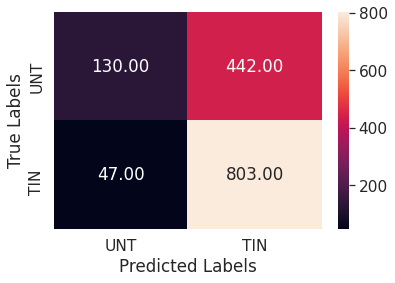

In [0]:
import seaborn as sn
import pandas as pd
import matplotlib.pyplot as plt



df_cm = pd.DataFrame(cnf,['UNT', 'TIN'], ['UNT', 'TIN'])
# plt.figure(figsize=(10,7))
sn.set(font_scale=1.4) # for label size
sn.heatmap(df_cm, annot=True,fmt='.2f') # font size
plt.xlabel("Predicted Labels")
plt.ylabel("True Labels")

plt.show()

In [0]:
np.squeeze(ygold).tolist().count("TIN")

850

In [0]:
np.squeeze(ygold).tolist().count("UNT")

572